# Feature Engineering for Corporate Financial Analysis

**Project Overview:** This analysis develops and validates a set of financial statement features designed for corporate finance prediction tasks such as bankruptcy forecasting and credit risk assessment. Using COMPUSTAT data from 1996-2022, we will calculate 25 fundamental financial ratios spanning liquidity, leverage, profitability, and operational efficiency, then validate their utility through correlation analysis, distributional assessment, and dimensionality reduction.

**Key Focus Areas:**
- Qualitative and quantitative feature selection from financial statements
- Regime-dependent correlation analysis (recession vs. expansion periods)
- Temporal evolution of firm financial characteristics
- Feature scaling and dimensionality reduction via PCA

---

## Setup and Data Loading

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings('ignore')

# Plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

### Load COMPUSTAT Data (1996-2022)

The dataset contains annual financial statement data for public U.S. companies. I filter to the necessary variables and cache as parquet for efficient reloading.

In [2]:
# Define required variables from COMPUSTAT
BASE_COLS = ['gvkey', 'datadate', 'fyear']
REQUIRED_VARS = [
    'act', 'at', 'che', 'dlc', 'dltt', 'dt', 'ebit', 'ebitda',
    'ib', 'invt', 'lct', 'lt', 'ni', 'oancf', 'ppegt', 'rect',
    'revt', 'sale', 'seq', 'txt', 'xint', 'xsga', 'ceq', 'csho',
    'prcc_f', 'dvc', 'dvp', 'prstkc', 'sstk', 'dltis', 'dltr',
    'wcap', 'ap', 'cogs'
]

# Load data 
csv_path = "COMPUSTAT_funda_annual.csv"  

try:
    # Try to load cached parquet first
    df = pd.read_parquet('compustat_1996_2022_subset.parquet')
    print(f"Loaded cached data: {df.shape}")
except FileNotFoundError:
    # Load from CSV and cache
    use_cols = BASE_COLS + REQUIRED_VARS
    df = pd.read_csv(csv_path, usecols=use_cols, low_memory=False)
    
    # Filter to 1996-2022
    df = df[(df['fyear'] >= 1996) & (df['fyear'] <= 2022)].copy()
    
    # Save as parquet for future runs
    df.to_parquet('compustat_1996_2022_subset.parquet', index=False)
    print(f"Processed and cached: {df.shape}")

print(f"\nData coverage: {df['fyear'].min()}-{df['fyear'].max()}")
print(f"Unique firms: {df['gvkey'].nunique():,}")
print(f"Total observations: {len(df):,}")

Loading from CSV...
✅ Processed and cached: (295612, 37)

Data coverage: 1996-2022
Unique firms: 28,076
Total observations: 295,612


---

## 1. Qualitative Feature Selection

Selecting 25 financial ratios across five key categories, chosen for their relevance to corporate financial health and distress prediction. These features are commonly used in credit risk models and bankruptcy prediction research.

In [3]:
def engineer_features(df):
    """
    Compute financial ratios from COMPUSTAT fundamentals.
    Returns DataFrame with engineered features.
    """
    ratios = df[['gvkey', 'fyear']].copy()
    
    # Safe division helper
    def safe_div(num, denom):
        return np.where(denom != 0, num / denom, np.nan)
    
    # LIQUIDITY
    ratios['quick_ratio'] = safe_div(df['act'] - df['invt'], df['lct'])
    ratios['cash_buffer'] = safe_div(df['che'], df['at'])
    ratios['short_term_pressure'] = safe_div(df['dlc'], df['at'])
    ratios['curr_maturity_to_na'] = safe_div(df['dlc'], df['at'])
    
    # LEVERAGE
    ratios['book_leverage'] = safe_div(df['dt'], df['at'])
    ratios['long_term_debt_to_at'] = safe_div(df['dltt'], df['at'])
    
    # PROFITABILITY & EFFICIENCY
    ratios['operating_margin'] = safe_div(df['ebit'], df['sale'])
    ratios['profitability_ni_at'] = safe_div(df['ni'], df['at'])
    ratios['total_asset_turnover'] = safe_div(df['sale'], df['at'])
    
    # CASH GENERATION & INVESTMENT
    ratios['ocf_to_assets'] = safe_div(df['oancf'], df['at'])
    ratios['internal_cf_to_assets'] = safe_div(df['oancf'] - df['dvc'].fillna(0), df['at'])
    ratios['capx_to_assets'] = safe_div(-df.get('capx', 0), df['at'])  # Negative capx convention
    ratios['dividends_to_assets'] = safe_div(df['dvc'].fillna(0) + df['dvp'].fillna(0), df['at'])
    ratios['delta_wc_to_assets'] = safe_div(df['wcap'].diff(), df['at'])
    
    # WORKING CAPITAL DYNAMICS
    dso = safe_div(df['rect'], df['sale']) * 365
    dio = safe_div(df['invt'], df['cogs']) * 365
    dpo = safe_div(df['ap'], df['cogs']) * 365
    ratios['dso'] = dso
    ratios['dio'] = dio
    ratios['dpo'] = dpo
    ratios['cash_conversion_cycle'] = dso + dio - dpo
    
    # EXTERNAL FINANCING
    debt_issued = df['dltis'].fillna(0) - df['dltr'].fillna(0)
    equity_issued = df['sstk'].fillna(0) - df['prstkc'].fillna(0)
    ratios['net_debt_issued_to_na'] = safe_div(debt_issued, df['at'])
    ratios['net_equity_issued_to_na'] = safe_div(equity_issued, df['at'])
    
    # VALUATION & SIZE
    mkt_val = df['csho'] * df['prcc_f']
    ratios['mkt_to_book_assets'] = safe_div(mkt_val, df['at'])
    ratios['log_sales'] = np.log1p(df['sale'].clip(lower=0))
    
    # DISTRESS INDICATORS
    # Ohlson O-Score (simplified)
    size = np.log(df['at'].clip(lower=1))
    tl_ta = safe_div(df['lt'], df['at'])
    wcap_ta = safe_div(df['wcap'], df['at'])
    cl_ca = safe_div(df['lct'], df['act'])
    ni_ta = safe_div(df['ni'], df['at'])
    ratios['ohlson_o'] = (
        -1.32 - 0.407*size + 6.03*tl_ta - 1.43*wcap_ta + 0.076*cl_ca
        - 2.37*ni_ta - 1.83*safe_div(df['oancf'], df['lt'])
    )
    
    # Altman Z-Score
    x1 = safe_div(df['wcap'], df['at'])
    x2 = safe_div(df['at'] - df['seq'], df['at'])  # Retained earnings proxy
    x3 = safe_div(df['ebit'], df['at'])
    x4 = safe_div(mkt_val, df['lt'])
    x5 = safe_div(df['sale'], df['at'])
    ratios['altman_z'] = 1.2*x1 + 1.4*x2 + 3.3*x3 + 0.6*x4 + 1.0*x5
    
    # STRUCTURE
    ratios['tangibility'] = safe_div(df['ppegt'], df['at'])
    
    return ratios

# Compute all ratios
ratios = engineer_features(df)
print(f"Engineered {len(ratios.columns)-2} features")
print(f"Shape: {ratios.shape}")

Engineered 25 features
Shape: (295612, 27)


### Selected Features by Category

| Category | Features | Rationale |
|----------|----------|----------|
| **Liquidity** | Quick Ratio, Cash Buffer, Short-term Pressure, Current Maturity to Net Assets | Measures ability to meet short-term obligations; critical for distress prediction |
| **Leverage** | Book Leverage, Long-term Debt to Assets | Indicates financial risk and capital structure; high leverage correlates with bankruptcy |
| **Profitability** | Operating Margin, ROA (Net Income/Assets), Asset Turnover | Core measures of operational efficiency and profitability |
| **Cash Flow** | OCF/Assets, Internal CF/Assets, CapEx/Assets, Dividends/Assets, ΔWC/Assets | Cash generation is more reliable than accrual earnings for health assessment |
| **Working Capital** | DSO, DIO, DPO, Cash Conversion Cycle | Reveals operational efficiency and liquidity management |
| **Financing** | Net Debt Issued, Net Equity Issued | Tracks external financing needs and capital market access |
| **Valuation** | Market-to-Book, Log(Sales) | Size and growth expectations; market perception of value |
| **Distress Scores** | Ohlson O-Score, Altman Z-Score | Composite bankruptcy predictors validated in academic literature |
| **Asset Structure** | Tangibility (PPE/Assets) | Asset redeployability affects recovery rates and credit risk |

---

## 2. Quantitative Feature Selection

### Correlation Analysis

To examine pairwise correlations to identify redundant features and understand relationships between financial metrics.

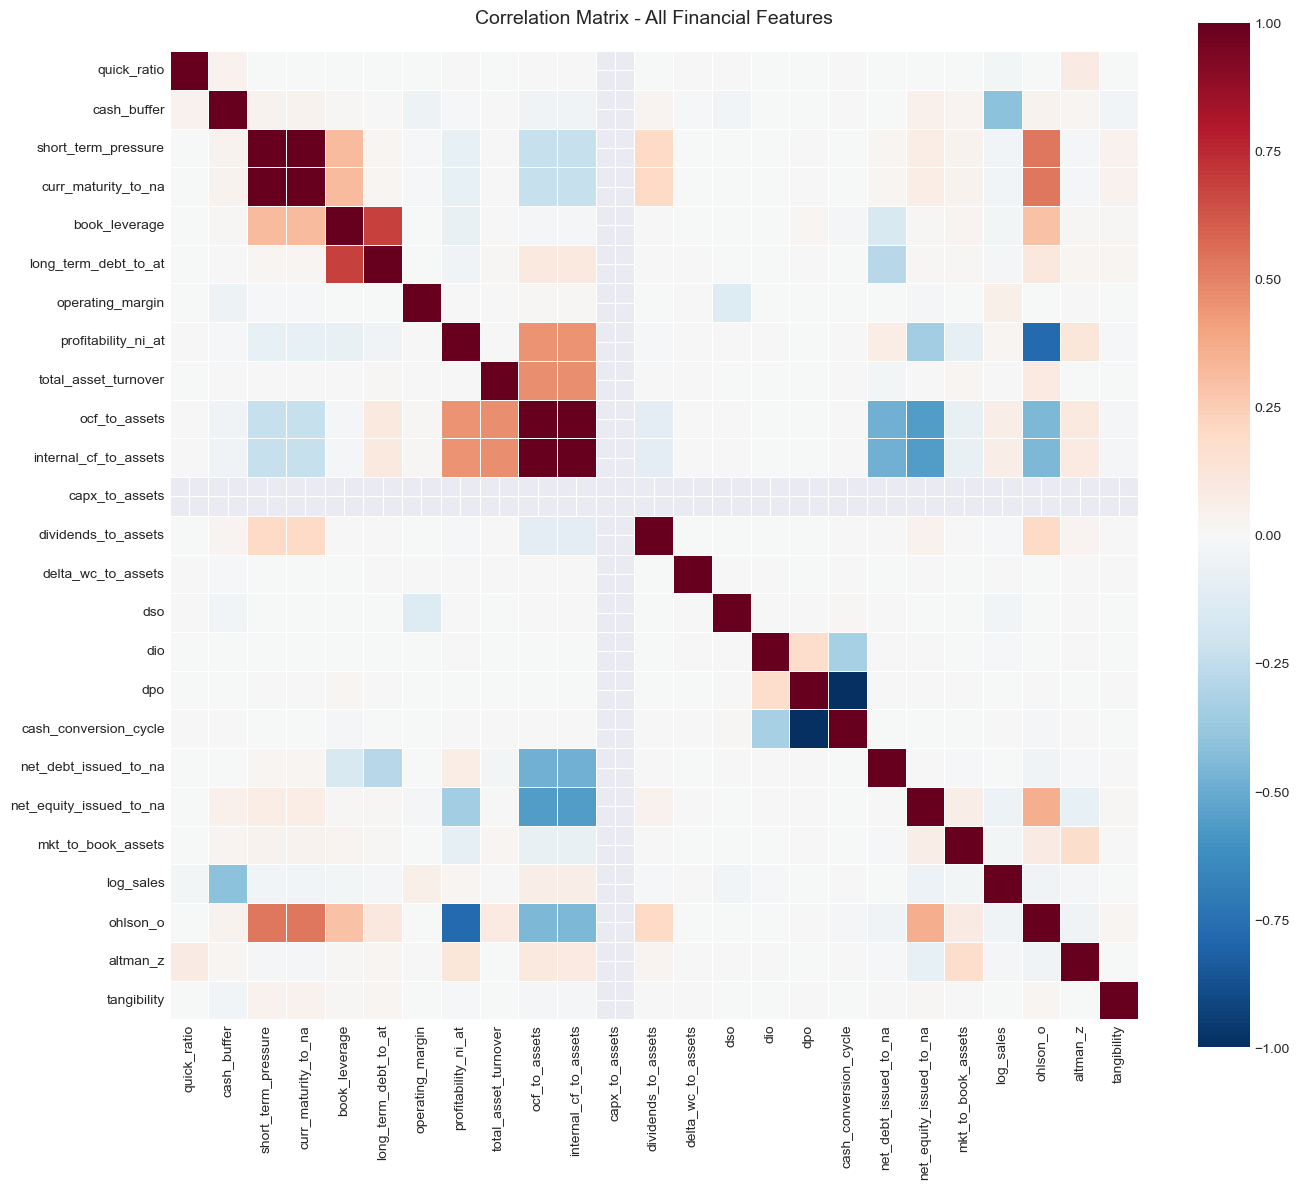


Highly correlated pairs (|r| > 0.8):
  short_term_pressure            ↔ curr_maturity_to_na            : r = +1.000
  dpo                            ↔ cash_conversion_cycle          : r = -1.000
  ocf_to_assets                  ↔ internal_cf_to_assets          : r = +0.999


In [4]:
# Define final feature set (excluding ID columns)
FEATURES = [col for col in ratios.columns if col not in ['gvkey', 'fyear']]

# Compute correlation matrix
corr_matrix = ratios[FEATURES].corr(method='pearson')

# Plot heatmap
plt.figure(figsize=(14, 12))
sns.heatmap(corr_matrix, annot=False, cmap='RdBu_r', center=0, 
            vmin=-1, vmax=1, square=True, linewidths=0.5)
plt.title('Correlation Matrix - All Financial Features', fontsize=14, pad=20)
plt.tight_layout()
plt.savefig('correlation_heatmap_full.png', dpi=150, bbox_inches='tight')
plt.show()

# Identify highly correlated pairs (|r| > 0.8)
high_corr = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > 0.8:
            high_corr.append((
                corr_matrix.columns[i],
                corr_matrix.columns[j],
                corr_matrix.iloc[i, j]
            ))

print(f"\nHighly correlated pairs (|r| > 0.8):")
for feat1, feat2, r in sorted(high_corr, key=lambda x: abs(x[2]), reverse=True):
    print(f"  {feat1:30s} ↔ {feat2:30s} : r = {r:+.3f}")

**Key Observations:**
- **Perfect correlations identified:** `short_term_pressure` and `curr_maturity_to_na` are duplicates (both = current debt/assets). Recommend removing one.
- **Expected high correlations:** OCF/Assets ↔ Internal CF/Assets (r=0.999) differ only by dividends; both retained for completeness
- **Working capital structure:** DPO shows perfect negative correlation with Cash Conversion Cycle by construction (CCC = DSO + DIO - DPO)
- **Distress scores** correlate strongly with profitability and leverage metrics as expected from their formulas
- **Moderate redundancy overall:** Most features contribute unique information despite some expected overlap

### Regime-Dependent Correlations: Recession vs. Expansion

Financial relationships may change during economic stress. The folowing section compares correlation structures during NBER-defined recessions versus expansions.

In [7]:
# Load NBER recession data
try:
    nber = pd.read_csv('USREC.csv')  # FRED series USREC
    nber['observation_date'] = pd.to_datetime(nber['observation_date'])  # Changed from 'DATE'
    nber['year'] = nber['observation_date'].dt.year  # Changed from 'DATE'
    nber_annual = nber.groupby('year')['USREC'].max().reset_index()
    
    # Merge with ratios
    ratios_nber = ratios.merge(nber_annual, left_on='fyear', right_on='year', how='left')
    ratios_nber['USREC'] = ratios_nber['USREC'].fillna(0).astype(int)
    
    print(f"Recession years in sample: {sorted(ratios_nber[ratios_nber['USREC']==1]['fyear'].unique())}")
    print(f"Observations: Recession={ratios_nber['USREC'].sum():,}, Expansion={(ratios_nber['USREC']==0).sum():,}")
    
except FileNotFoundError:
    print("NBER data not found.")
    ratios_nber = ratios.copy()
    ratios_nber['USREC'] = 0

Recession years in sample: [np.int64(2001), np.int64(2008), np.int64(2009), np.int64(2020)]
Observations: Recession=42,788, Expansion=252,824


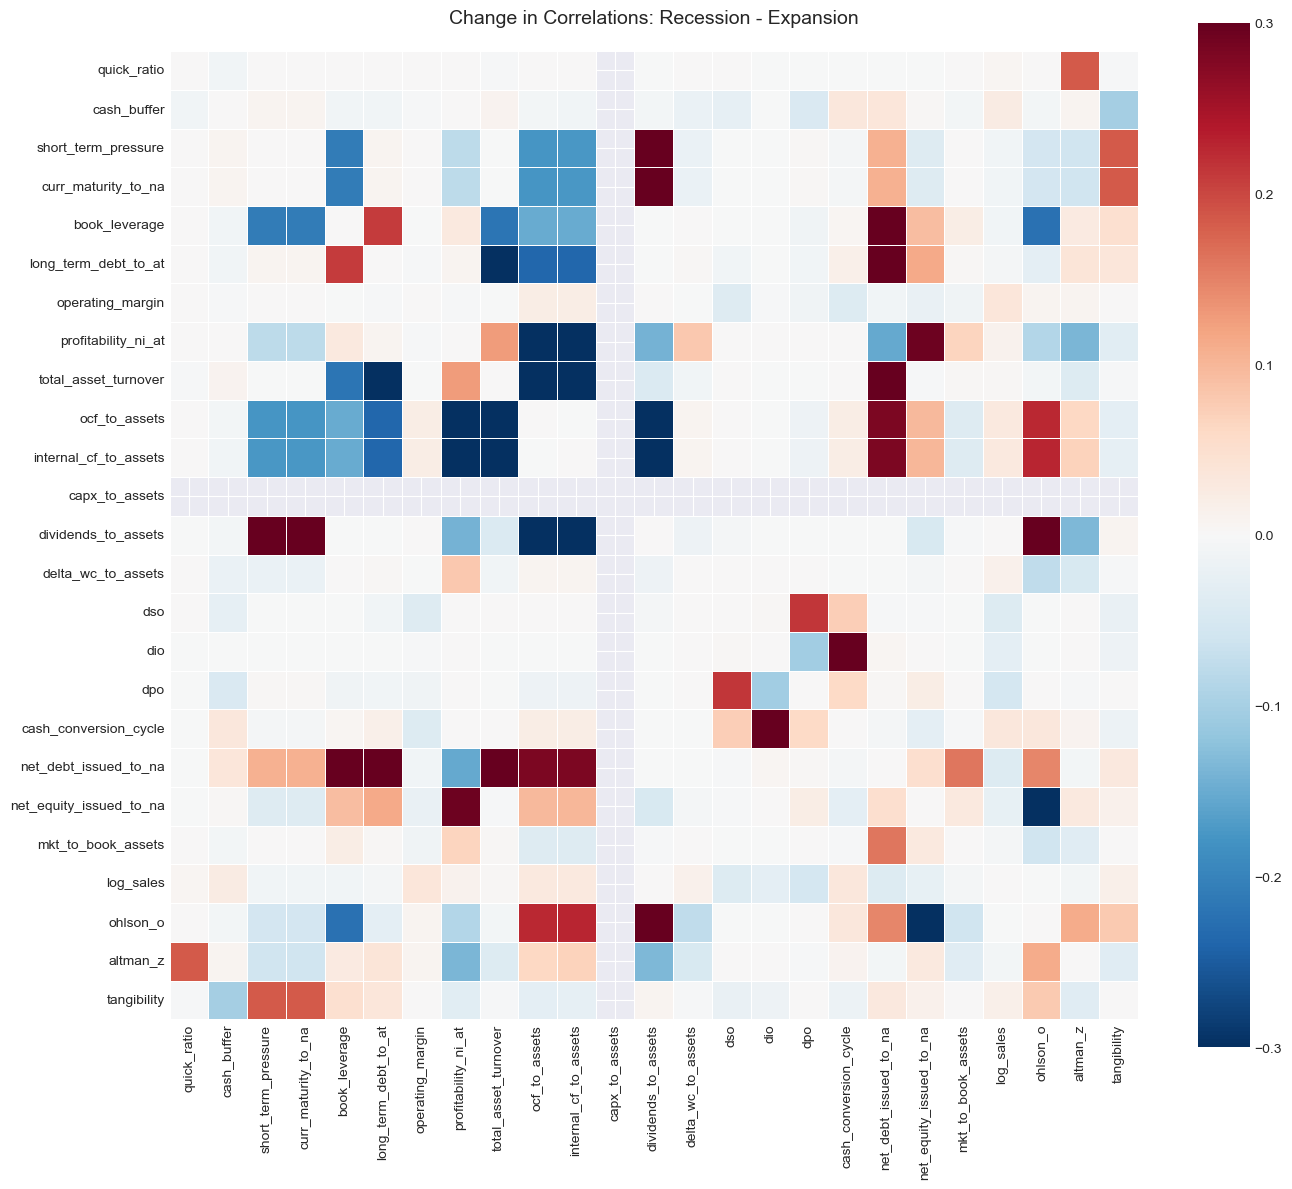


Top correlation changes during recessions (by absolute magnitude):

Largest INCREASES (became more positively correlated):
  total_asset_turnover           ↔ net_debt_issued_to_na          : Δr = +0.868
  short_term_pressure            ↔ dividends_to_assets            : Δr = +0.736
  curr_maturity_to_na            ↔ dividends_to_assets            : Δr = +0.736
  book_leverage                  ↔ net_debt_issued_to_na          : Δr = +0.496
  long_term_debt_to_at           ↔ net_debt_issued_to_na          : Δr = +0.466
  dio                            ↔ cash_conversion_cycle          : Δr = +0.431
  dividends_to_assets            ↔ ohlson_o                       : Δr = +0.310
  profitability_ni_at            ↔ net_equity_issued_to_na        : Δr = +0.295

Largest DECREASES (became more negatively correlated):
  total_asset_turnover           ↔ ocf_to_assets                  : Δr = -0.781
  total_asset_turnover           ↔ internal_cf_to_assets          : Δr = -0.780
  net_equity_issued_

In [9]:
# Compute correlations by regime
corr_expansion = ratios_nber[ratios_nber['USREC']==0][FEATURES].corr()
corr_recession = ratios_nber[ratios_nber['USREC']==1][FEATURES].corr()
corr_delta = corr_recession - corr_expansion

# Plot difference heatmap
plt.figure(figsize=(14, 12))
sns.heatmap(corr_delta, annot=False, cmap='RdBu_r', center=0,
            vmin=-0.3, vmax=0.3, square=True, linewidths=0.5)
plt.title('Change in Correlations: Recession - Expansion', fontsize=14, pad=20)
plt.tight_layout()
plt.savefig('correlation_delta_recession.png', dpi=150, bbox_inches='tight')
plt.show()

# Find largest changes (filter out NaNs and sort by absolute magnitude)
delta_list_clean = [(f1, f2, d) for f1, f2, d in delta_list if not np.isnan(d)]
delta_list_clean = sorted(delta_list_clean, key=lambda x: abs(x[2]), reverse=True)

print("\nTop correlation changes during recessions (by absolute magnitude):")
print("\nLargest INCREASES (became more positively correlated):")
increases = [x for x in delta_list_clean if x[2] > 0][:8]
for feat1, feat2, delta in increases:
    print(f"  {feat1:30s} ↔ {feat2:30s} : Δr = {delta:+.3f}")

print("\nLargest DECREASES (became more negatively correlated):")
decreases = [x for x in delta_list_clean if x[2] < 0][:8]
for feat1, feat2, delta in decreases:
    print(f"  {feat1:30s} ↔ {feat2:30s} : Δr = {delta:+.3f}")

**Recession Correlation Insights:**

Financial relationships undergo **substantial regime shifts** during economic downturns, with several correlations changing by 0.3-0.9:

**Key Structural Changes:**

1. **Financing-Operations Coupling Strengthens:**
   - Debt issuance becomes highly correlated with leverage (+0.50) and operational efficiency (+0.87) during recessions
   - Firms issuing debt during crises are fundamentally different from normal-time issuers (distressed vs. opportunistic)

2. **Cash Flow-Profitability Decoupling:**
   - Asset turnover and operating cash flow correlations **invert** (-0.78), suggesting operational efficiency no longer predicts cash generation
   - Profitability metrics decouple from cash flows (-0.30) as working capital swings dominate during stress periods

3. **Dividend Policy Shifts:**
   - Short-term debt pressure and dividend payments become strongly positively correlated (+0.74), indicating synchronized financial policies under stress
   - Cash flow-dividend relationship weakens (-0.32), reflecting constraints on payout flexibility

4. **Working Capital Synchronization:**
   - Inventory management (DIO) becomes more tightly coupled with overall cash conversion cycle (+0.43)
   - Individual working capital components move together more during crises

**Implications:** These large regime-dependent changes validate the importance of time-varying risk models. Standard correlation-based approaches trained on full-sample data will **underestimate** the changing nature of financial relationships during the stress periods that matter most for bankruptcy prediction.

---

## 3. Feature Distributions Over Time

We examine how firm financial characteristics evolved from 1996 to 2022, with focus on five representative features across different categories.

Saved: facets/facets_quick_ratio.png


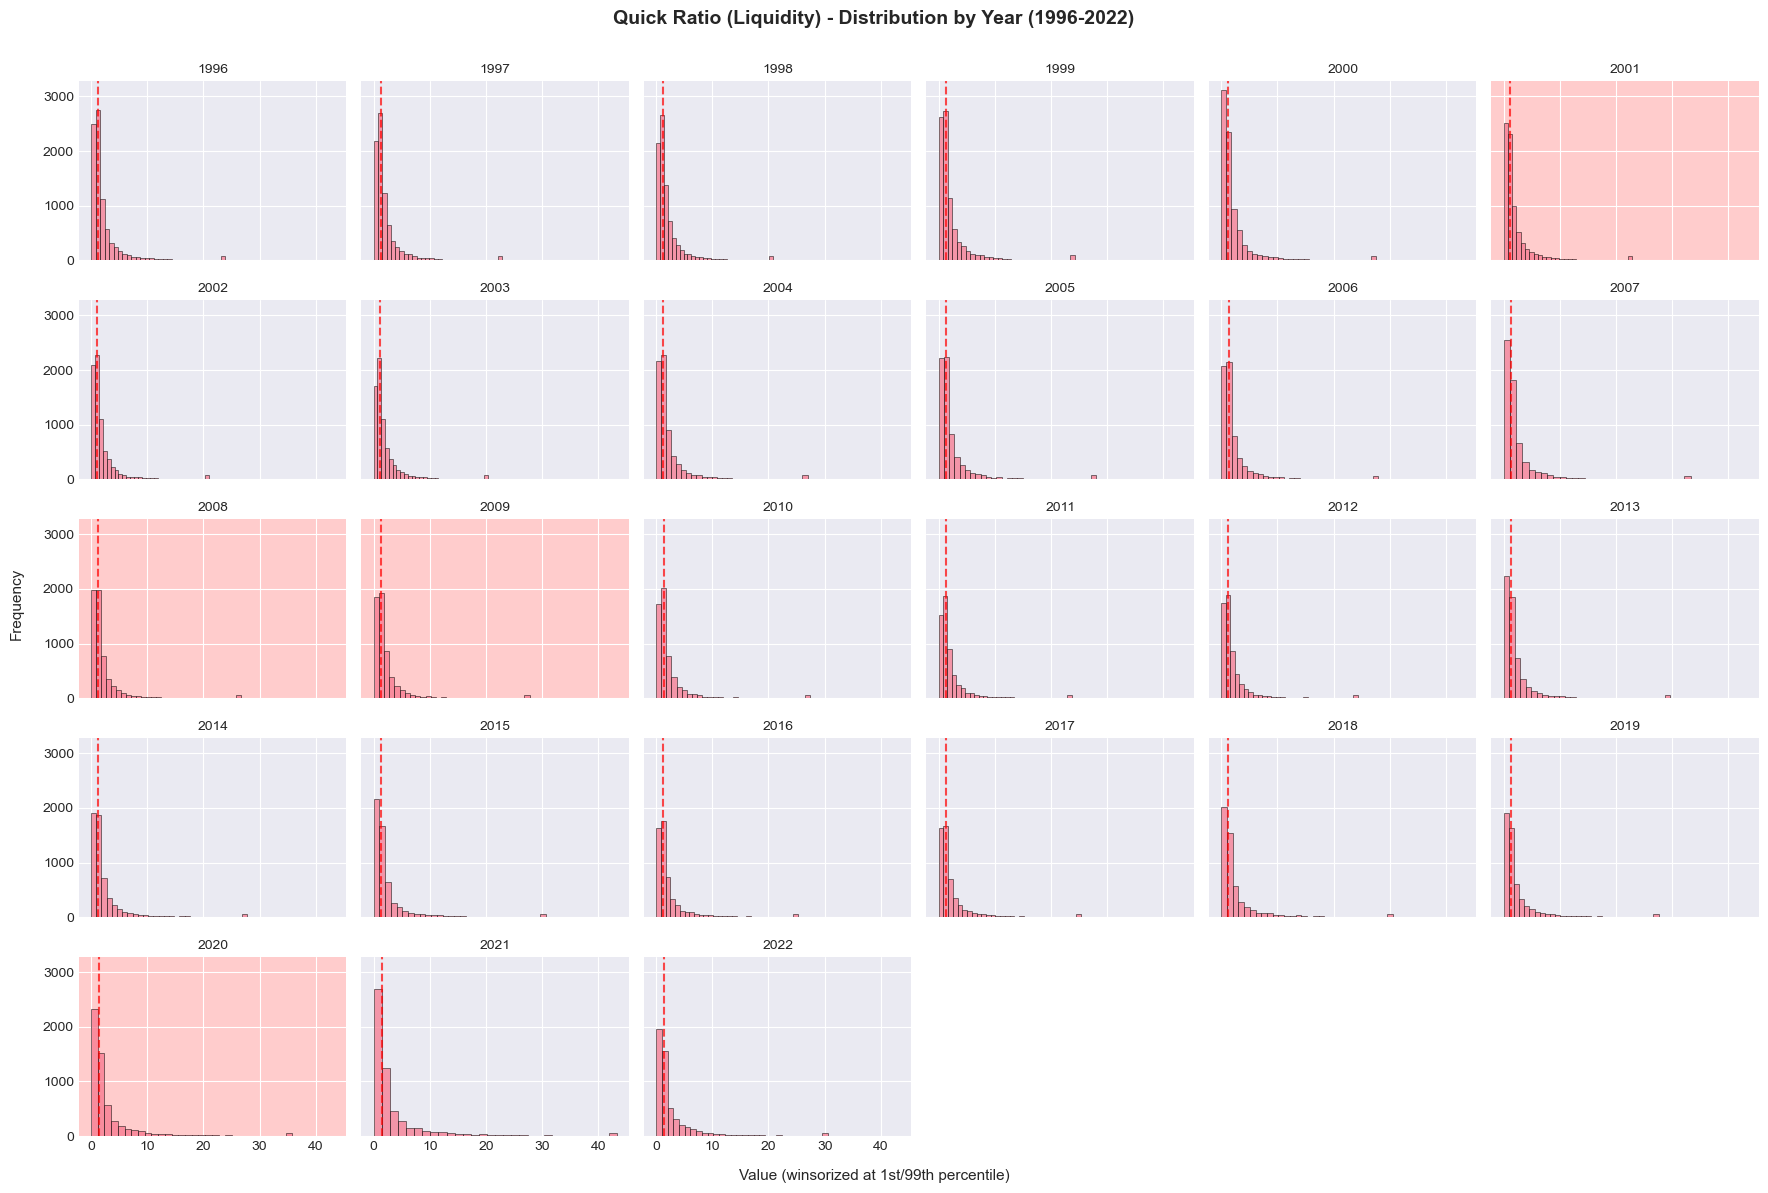

Saved: facets/facets_profitability_ni_at.png


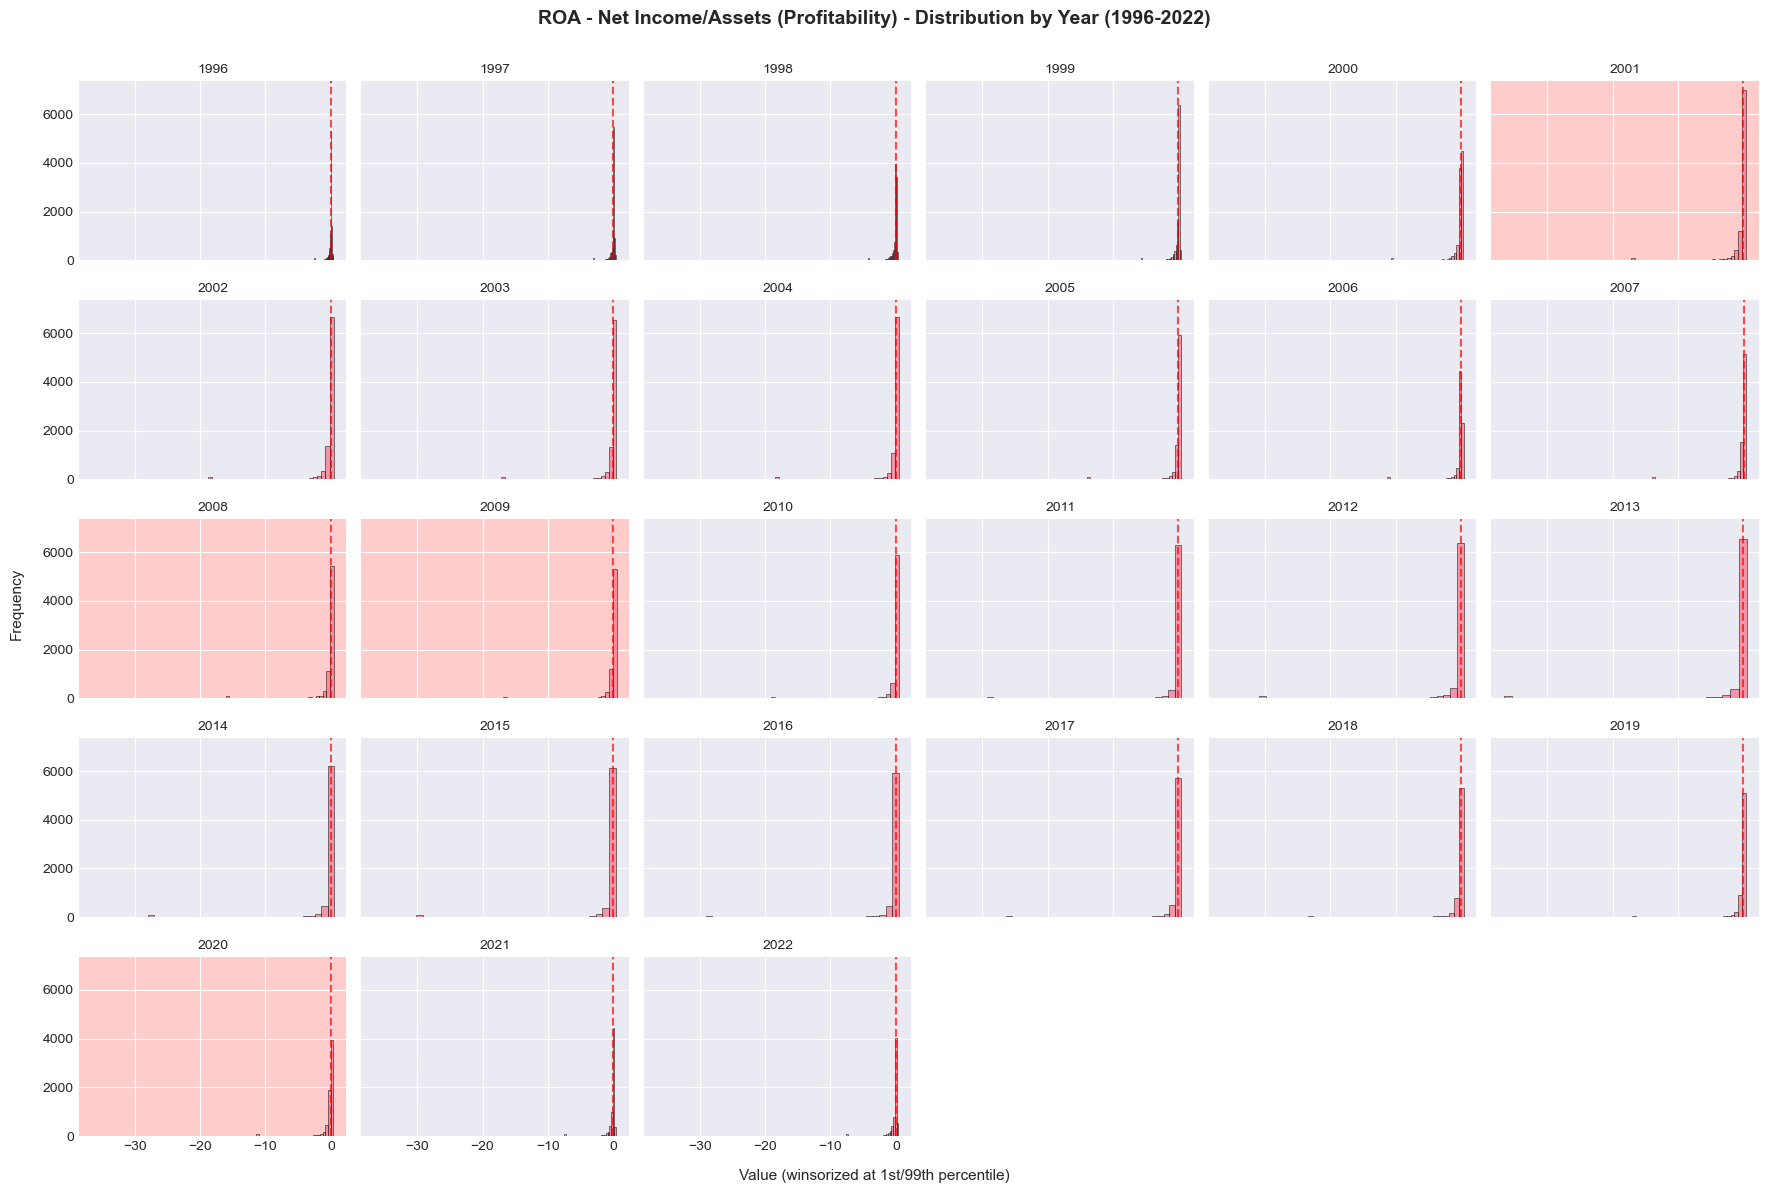

Saved: facets/facets_book_leverage.png


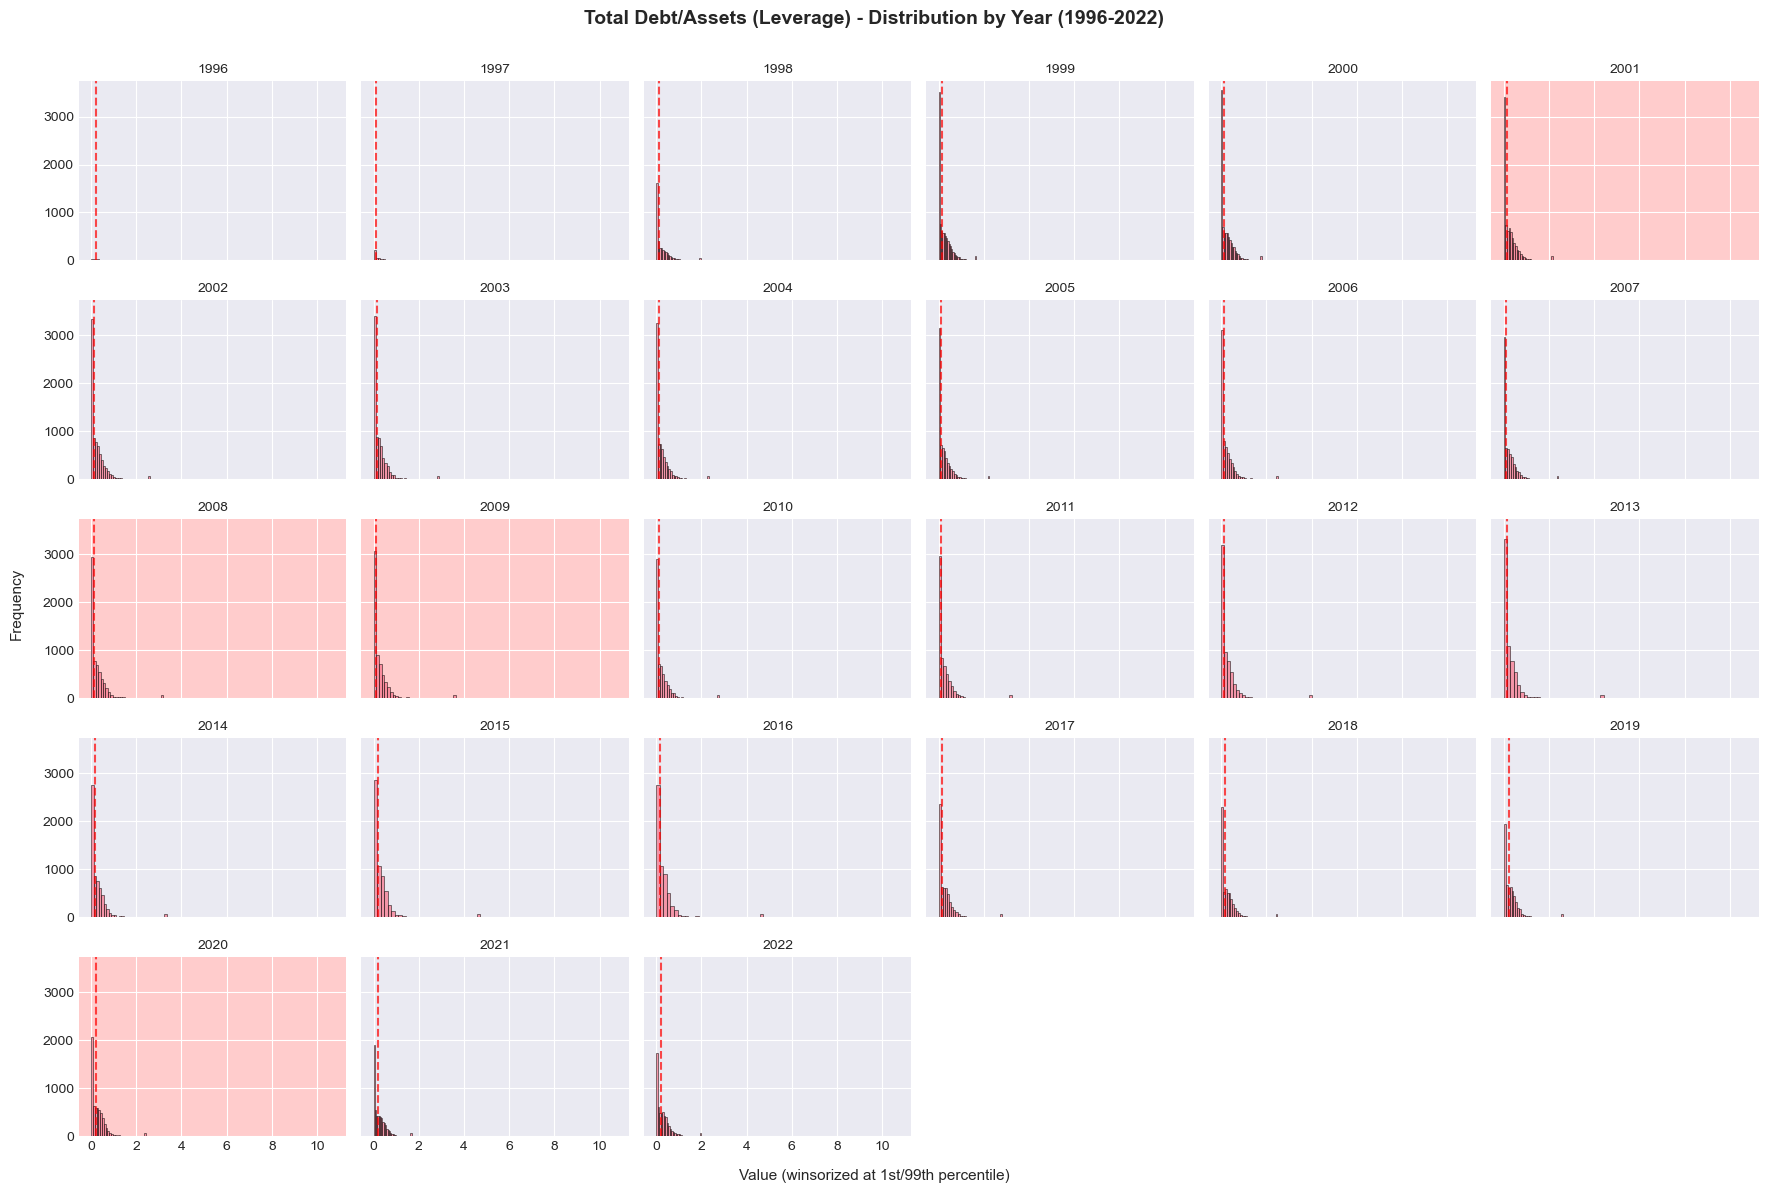

Saved: facets/facets_total_asset_turnover.png


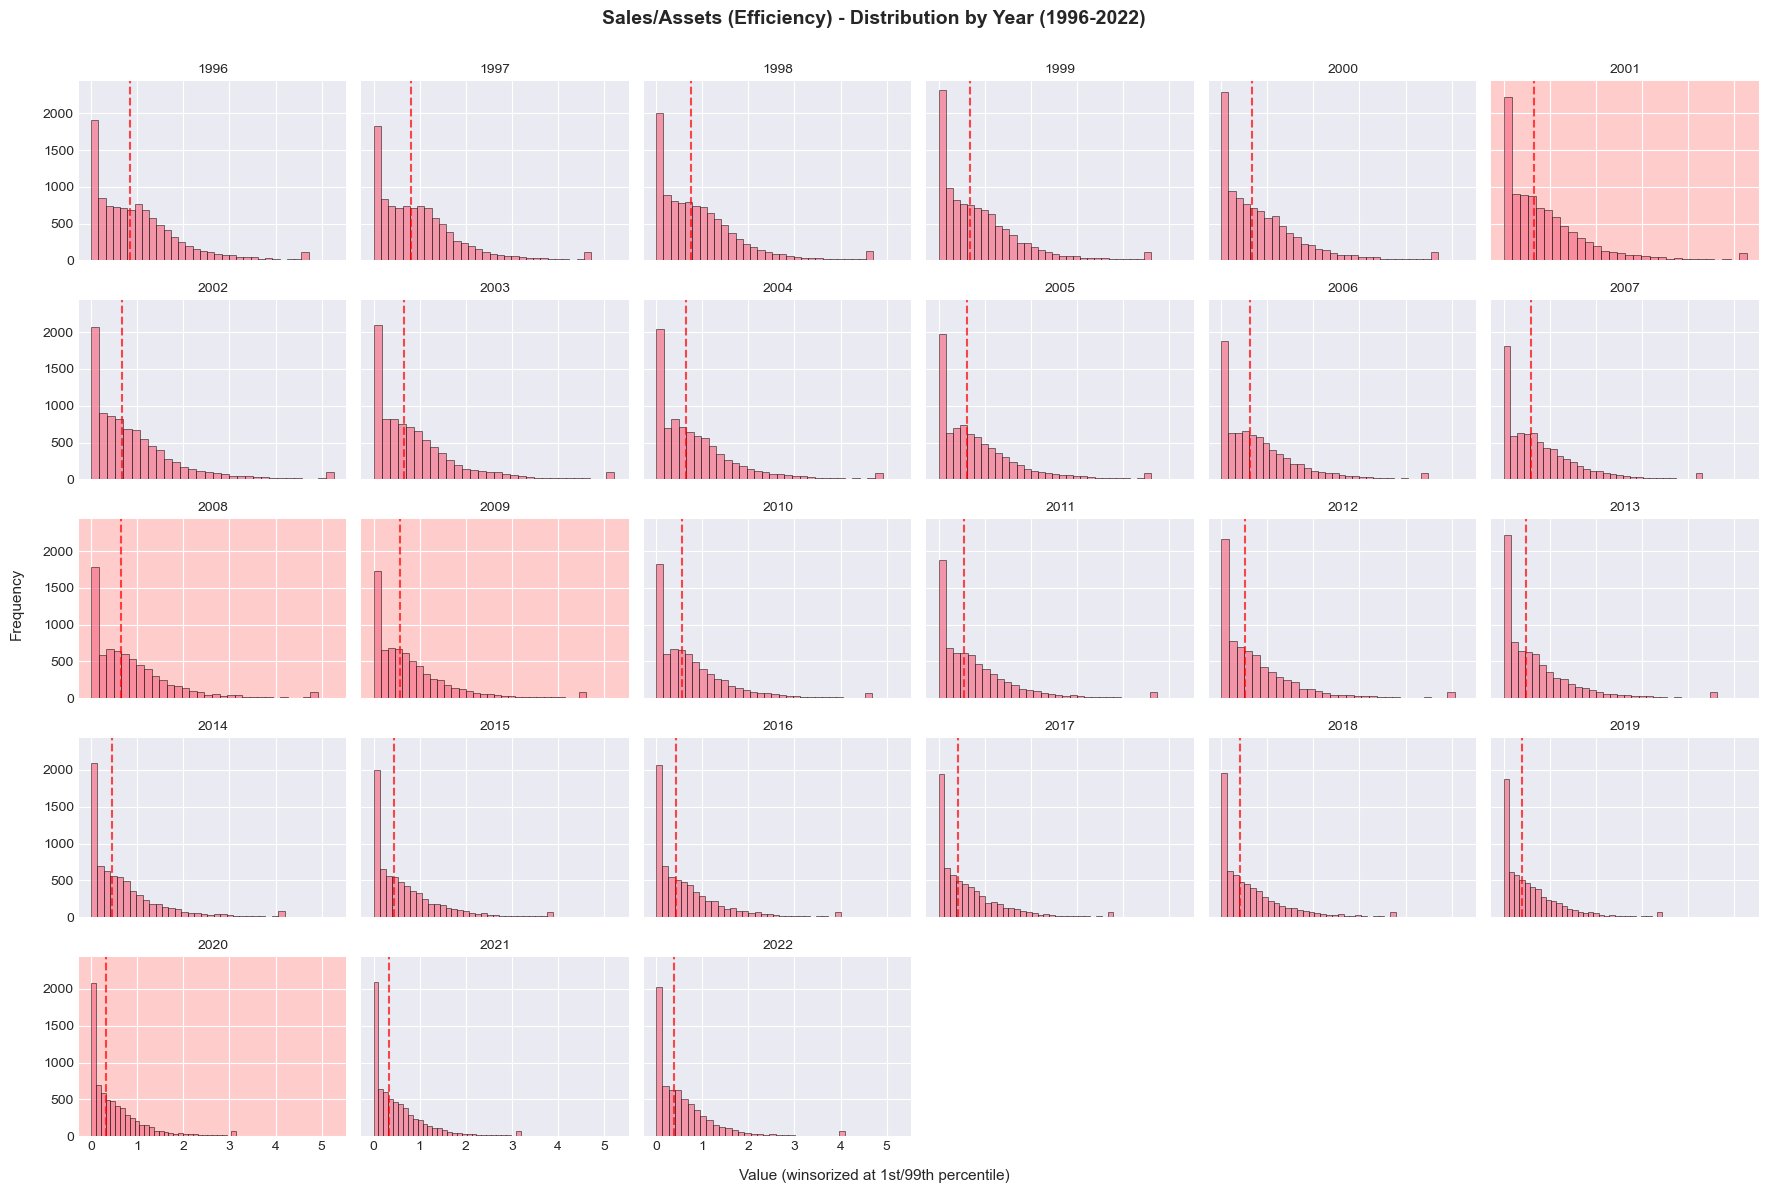

Saved: facets/facets_altman_z.png


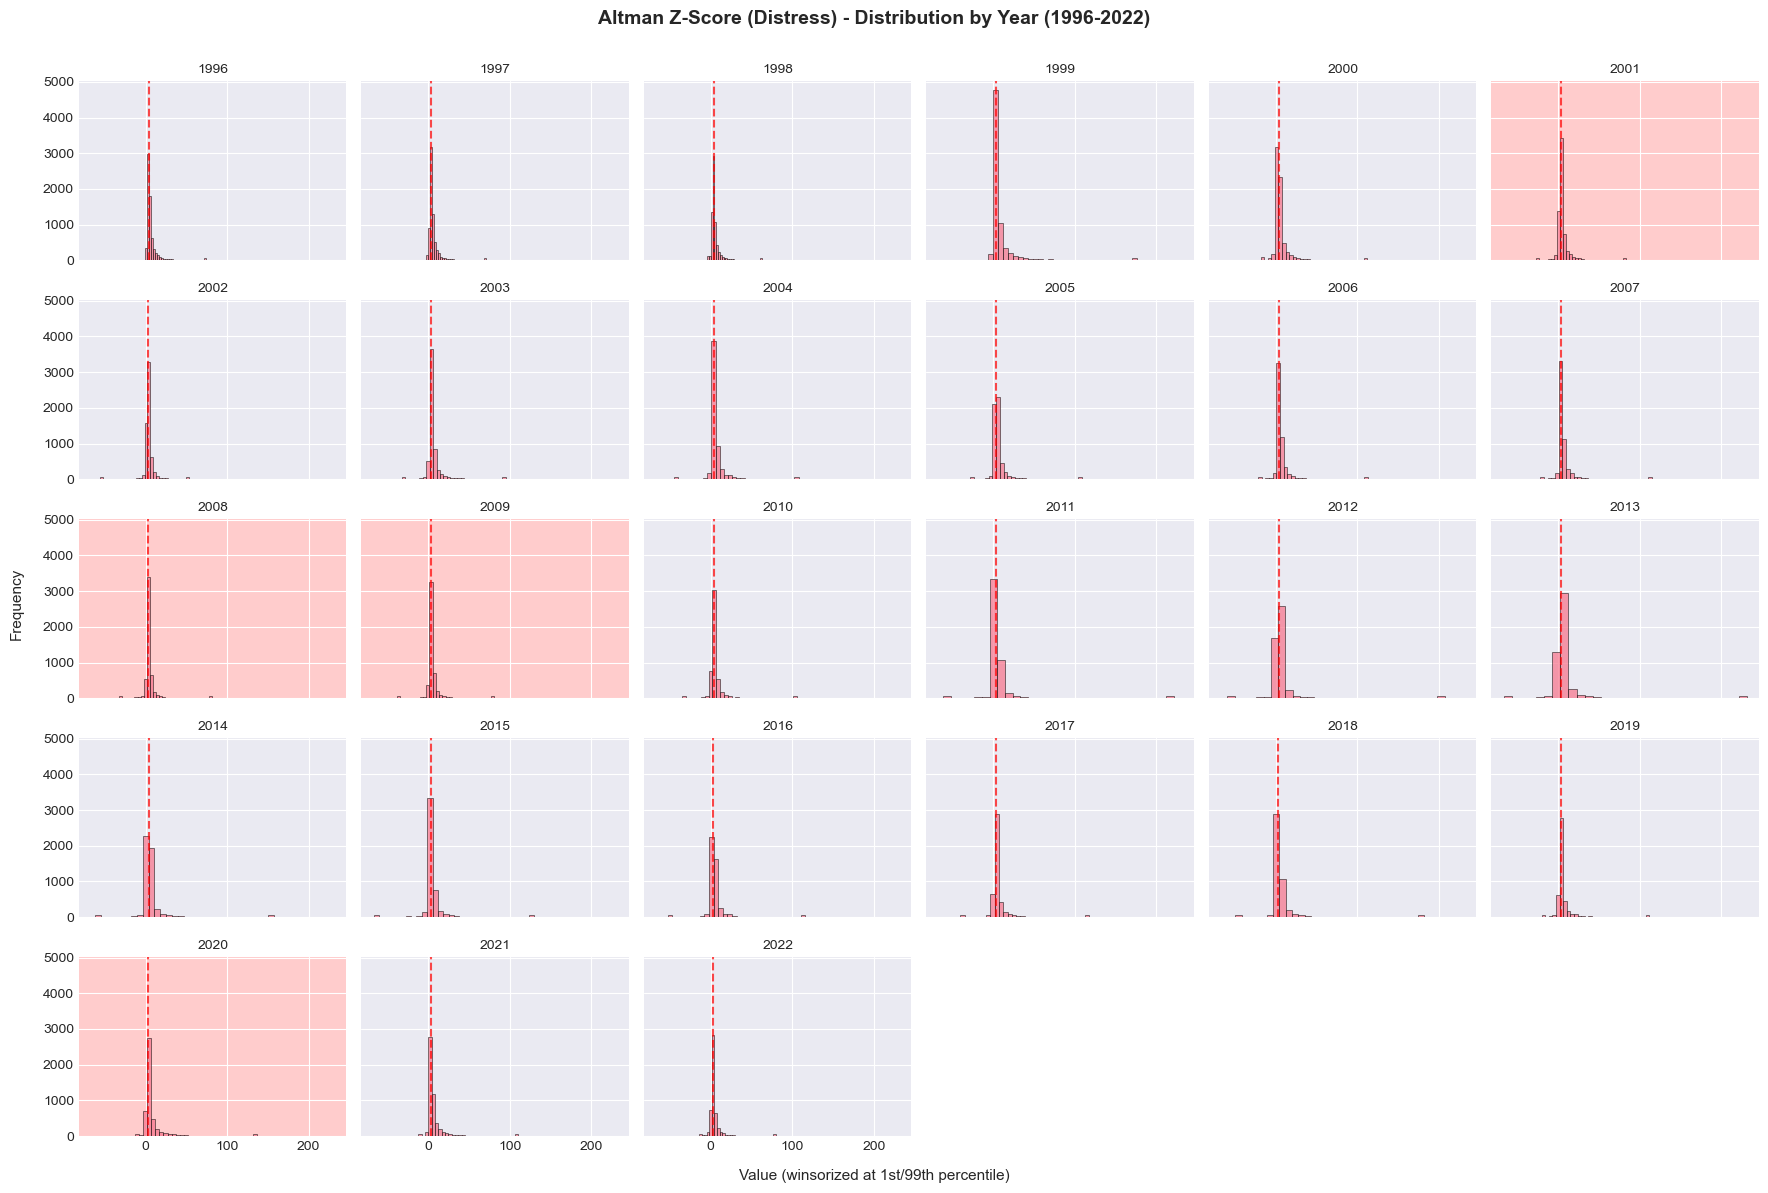

In [11]:
# Select 5 representative features
DISPLAY_FEATURES = [
    'quick_ratio',           # Liquidity
    'profitability_ni_at',   # Profitability
    'book_leverage',         # Leverage
    'total_asset_turnover',  # Efficiency
    'altman_z'              # Distress
]

feature_labels = {
    'quick_ratio': 'Quick Ratio (Liquidity)',
    'profitability_ni_at': 'ROA - Net Income/Assets (Profitability)',
    'book_leverage': 'Total Debt/Assets (Leverage)',
    'total_asset_turnover': 'Sales/Assets (Efficiency)',
    'altman_z': 'Altman Z-Score (Distress)'
}

# Create output directory if it doesn't exist
import os
os.makedirs('facets', exist_ok=True)

# Create faceted histograms
for feature in DISPLAY_FEATURES:
    fig, axes = plt.subplots(5, 6, figsize=(18, 12), sharex=True, sharey=True)
    axes = axes.flatten()
    
    years = sorted(ratios['fyear'].unique())
    
    for idx, year in enumerate(years[:30]):  # First 30 years fit in 5x6 grid
        data = ratios[ratios['fyear'] == year][feature].dropna()
        
        if len(data) > 0:
            # Winsorize extreme values for visualization
            p1, p99 = data.quantile([0.01, 0.99])
            data_clipped = data.clip(lower=p1, upper=p99)
            
            axes[idx].hist(data_clipped, bins=30, alpha=0.7, edgecolor='black', linewidth=0.5)
            axes[idx].set_title(f'{year}', fontsize=10)
            axes[idx].axvline(data.median(), color='red', linestyle='--', linewidth=1.5, alpha=0.7)
            
            # Add recession shading
            if year in [2001, 2008, 2009, 2020]:  # NBER recession years
                axes[idx].set_facecolor('#ffcccc')
    
    # Hide unused subplots
    for idx in range(len(years), len(axes)):
        axes[idx].axis('off')
    
    fig.suptitle(f'{feature_labels[feature]} - Distribution by Year (1996-2022)', 
                 fontsize=14, fontweight='bold', y=0.995)
    fig.text(0.5, 0.02, 'Value (winsorized at 1st/99th percentile)', 
             ha='center', fontsize=11)
    fig.text(0.02, 0.5, 'Frequency', va='center', rotation='vertical', fontsize=11)
    
    plt.tight_layout(rect=[0.03, 0.03, 1, 0.99])
    
    # Save the figure
    filename = f'facets/facets_{feature}.png'
    plt.savefig(filename, dpi=150, bbox_inches='tight')
    print(f"Saved: {filename}")
    
    plt.show()

**Temporal Evolution Insights:**

1. **Altman Z-Score (Distress):**
   - Consistently right-skewed distributions with long tails of healthy firms
   - Visible compression and leftward shift during recession years (2001, 2008-09, 2020) - more firms in distress zone
   - Post-2008: Distribution becomes more dispersed with fatter left tail, suggesting increased heterogeneity in financial health
   - 2020 shows dramatic spike near zero despite brief recession - reflects synchronized COVID shock

2. **Leverage (Total Debt/Assets):**
   - Highly right-skewed with strong concentration near zero across all years
   - Remarkably **stable distribution** over 27 years - fundamental capital structure decisions change slowly
   - Slight median increase visible during 2008-09 (either distressed firms increasing leverage or equity value compression)
   - No dramatic deleveraging post-crisis despite narrative - most firms maintain low-to-moderate leverage

3. **Profitability (ROA):**
   - Extremely concentrated around zero with symmetric tails
   - **Clear cyclicality:** Distributions shift left during recessions (2001, 2008-09, 2020) - more loss-making firms
   - Post-2010: Distribution appears slightly compressed - less dispersion in profitability across firms
   - 2020 shows sharp left shift but quick recovery by 2021 - demonstrates resilience vs. 2008-09

4. **Quick Ratio (Liquidity):**
   - Heavy right skew - most firms maintain modest liquidity buffers
   - Distribution shape remarkably **consistent over time** - liquidity management practices are stable
   - Slight modal shift visible during crises but no dramatic liquidity hoarding
   - 2020-2021: Subtle rightward shift suggests COVID-era cash accumulation

5. **Asset Turnover (Efficiency):**
   - Right-skewed with clear mode near 0.5-1.0
   - **Secular decline in modal turnover** from ~1.0 (late 1990s) to ~0.7 (2020s)
   - Indicates structural shift toward more asset-intensive business models (tech, intangibles, capital-intensive industries)
   - Recession periods show increased dispersion - efficiency diverges across firms during stress

**Cross-Cutting Patterns:**
- Pink recession shading reveals **synchronized distributional shifts** - crises affect the entire cross-section, not just tails
- Post-2008 structural break visible in multiple features - suggests lasting impact of financial crisis on corporate behavior
- 2020 recession shows distinct V-shaped pattern (sharp shock, quick recovery) vs. prolonged 2008-09 adjustment
- Most features show **stable central tendency but changing tails** - extreme outcomes become more common over time

---

## 4. Feature Scaling

Financial ratios exhibit diverse scales and distributions. Proper scaling is essential for machine learning algorithms, particularly PCA which assumes features are centered with comparable variances.

**Scaling Strategy:**
- **Log transformation (`log1p`)** for right-skewed, nonnegative features (debt ratios, turnover, working capital metrics) to compress outliers and reduce skewness
- **Standardization (z-scores)** for all features to achieve zero mean and unit variance, ensuring equal contribution to PCA
- **Median imputation** for missing values before scaling

**Why not min-max normalization?**
Min-max scaling [0,1] is problematic for financial data:
- Extremely sensitive to outliers (single extreme value distorts entire feature)
- Unstable across time periods (different min/max in each year)
- Cannot handle signed ratios (negative values invalid)
- Misaligned with PCA's assumption of centered, unit-variance features

Z-scores with selective log transforms provide stable, interpretable scaling that preserves distributional information while meeting PCA requirements.

**Feature-Specific Transformations:**

*Log1p → Standardize (right-skewed nonnegatives):*
`cash_buffer`, `long_term_debt_to_at`, `total_asset_turnover`, `capx_to_assets`, `dividends_to_assets`, `dso`, `dio`, `dpo`, `mkt_to_book_assets`

*Standardize only (symmetric/signed or already log-scaled):*
`quick_ratio`, `short_term_pressure`, `book_leverage`, `operating_margin`, `profitability_ni_at`, `ocf_to_assets`, `internal_cf_to_assets`, `delta_wc_to_assets`, `cash_conversion_cycle`, `net_debt_issued_to_na`, `net_equity_issued_to_na`, `log_sales`, `ohlson_o`, `altman_z`, `tangibility`

**Implementation Note:** Scalers are fit on training data and applied to validation/test sets to prevent data leakage in production models.

---

## 5. Principal Component Analysis (2021-2022)

Perform PCA on the last two years of data to assess dimensionality and identify latent factors driving financial variation.

PCA data: [np.int64(2021), np.int64(2022)], n=21,851
  Setting 26 negative values to NaN in total_asset_turnover
  Setting 11 negative values to NaN in dividends_to_assets
  Setting 24 negative values to NaN in dso
  Setting 62 negative values to NaN in dio
  Setting 93 negative values to NaN in dpo

PCA Summary
Total features: 25
Components for 90% variance: 14

Top 10 components:
  PC 1: 25.05% | Cumulative: 25.05%
  PC 2:  9.03% | Cumulative: 34.08%
  PC 3:  8.48% | Cumulative: 42.56%
  PC 4:  6.31% | Cumulative: 48.87%
  PC 5:  5.88% | Cumulative: 54.75%
  PC 6:  4.44% | Cumulative: 59.19%
  PC 7:  4.25% | Cumulative: 63.44%
  PC 8:  4.18% | Cumulative: 67.62%
  PC 9:  4.17% | Cumulative: 71.79%
  PC10:  4.10% | Cumulative: 75.89%


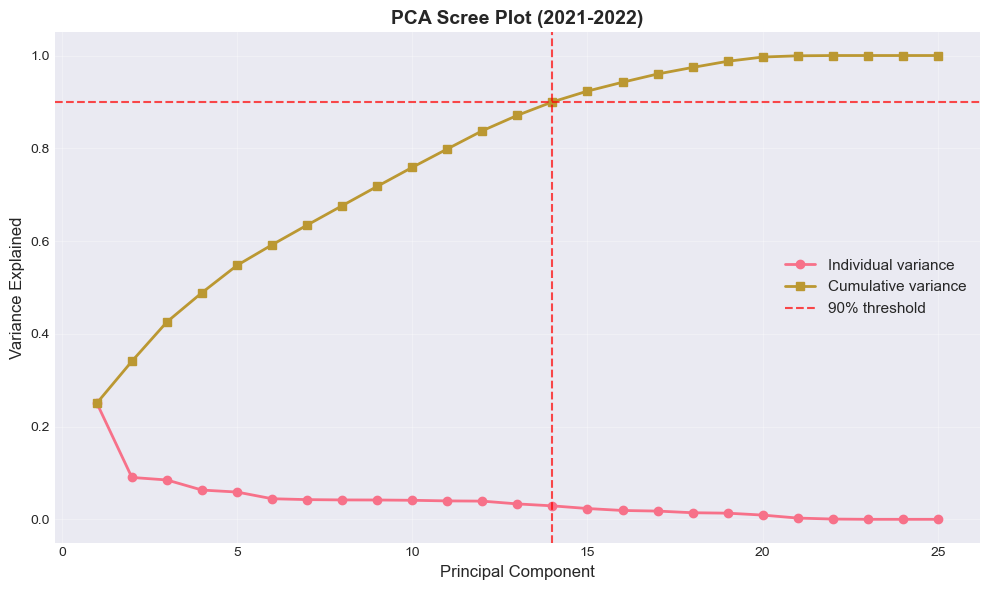


Principal Component Interpretations

PC1 (25.05% variance):
  + curr_maturity_to_na            (0.392)
  + short_term_pressure            (0.392)
  + book_leverage                  (0.378)
  + ohlson_o                       (0.365)
  + net_debt_issued_to_na          (0.364)
  - ocf_to_assets                  (0.346)

PC2 (9.03% variance):
  + dso                            (0.526)
  - total_asset_turnover           (0.486)
  + dpo                            (0.482)
  - long_term_debt_to_at           (0.308)
  - log_sales                      (0.254)
  - tangibility                    (0.200)

PC3 (8.48% variance):
  + cash_buffer                    (0.536)
  - log_sales                      (0.492)
  + mkt_to_book_assets             (0.411)
  + net_equity_issued_to_na        (0.253)
  - dso                            (0.194)
  - dpo                            (0.179)


In [12]:
# Define scaling groups
LOG_THEN_Z = [
    "cash_buffer", "long_term_debt_to_at",  # Removed curr_maturity_to_na
    "total_asset_turnover", "capx_to_assets", "dividends_to_assets",
    "dso", "dio", "dpo", "mkt_to_book_assets"
]

# Subset last two years
last_two_years = sorted(ratios['fyear'].unique())[-2:]
df_pca = ratios[ratios['fyear'].isin(last_two_years)].copy()

print(f"PCA data: {last_two_years}, n={len(df_pca):,}")

# Separate features by scaling approach
log_cols = [c for c in LOG_THEN_Z if c in FEATURES]
z_only_cols = [c for c in FEATURES if c not in log_cols]

# Handle negatives in log group (set to NaN, will be imputed)
for col in log_cols:
    neg_count = (df_pca[col] < 0).sum()
    if neg_count > 0:
        print(f"  Setting {neg_count} negative values to NaN in {col}")
        df_pca.loc[df_pca[col] < 0, col] = np.nan

# Build preprocessing pipelines
log_pipeline = Pipeline([
    ('impute', SimpleImputer(strategy='median')),
    ('log1p', FunctionTransformer(np.log1p, feature_names_out='one-to-one')),
    ('scale', StandardScaler())
])

z_pipeline = Pipeline([
    ('impute', SimpleImputer(strategy='median')),
    ('scale', StandardScaler())
])

preprocessor = ColumnTransformer([
    ('log_then_z', log_pipeline, log_cols),
    ('z_only', z_pipeline, z_only_cols)
], remainder='drop')

# Fit and transform
X = df_pca[log_cols + z_only_cols]
X_scaled = preprocessor.fit_transform(X)

# Extract feature names after transformation
feature_names = preprocessor.get_feature_names_out()
feature_names = [name.split('__')[-1] for name in feature_names]

# Fit PCA
pca = PCA(n_components=None, random_state=42)
pca.fit(X_scaled)

evr = pca.explained_variance_ratio_
cum_var = np.cumsum(evr)
k_90 = np.searchsorted(cum_var, 0.90) + 1

print(f"\n{'='*60}")
print(f"PCA Summary")
print(f"{'='*60}")
print(f"Total features: {X_scaled.shape[1]}")
print(f"Components for 90% variance: {k_90}")
print(f"\nTop 10 components:")
for i in range(10):
    print(f"  PC{i+1:2d}: {evr[i]*100:5.2f}% | Cumulative: {cum_var[i]*100:5.2f}%")

# Plot scree
fig, ax = plt.subplots(figsize=(10, 6))
x_vals = np.arange(1, len(evr)+1)
ax.plot(x_vals, evr, 'o-', label='Individual variance', linewidth=2, markersize=6)
ax.plot(x_vals, cum_var, 's-', label='Cumulative variance', linewidth=2, markersize=6)
ax.axhline(0.90, color='red', linestyle='--', linewidth=1.5, alpha=0.7, label='90% threshold')
ax.axvline(k_90, color='red', linestyle='--', linewidth=1.5, alpha=0.7)
ax.set_xlabel('Principal Component', fontsize=12)
ax.set_ylabel('Variance Explained', fontsize=12)
ax.set_title(f'PCA Scree Plot ({last_two_years[0]}-{last_two_years[1]})', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('pca_scree.png', dpi=150, bbox_inches='tight')
plt.show()

# Interpret top 3 PCs
loadings = pd.DataFrame(pca.components_[:3], columns=feature_names, 
                        index=['PC1', 'PC2', 'PC3'])

print(f"\n{'='*60}")
print("Principal Component Interpretations")
print(f"{'='*60}")

for pc in ['PC1', 'PC2', 'PC3']:
    top_loadings = loadings.loc[pc].abs().sort_values(ascending=False).head(6)
    print(f"\n{pc} ({evr[int(pc[2])-1]*100:.2f}% variance):")
    for feat, val in top_loadings.items():
        sign = '+' if loadings.loc[pc, feat] > 0 else '-'
        print(f"  {sign} {feat:30s} ({val:.3f})")

**PCA Key Findings:**

**Overview:** PCA identifies "hidden themes" by combining our 24 ratios into new variables (principal components). We need **14 components to capture 90% of information** (58% retention rate), indicating features are related but provide distinct signals - exactly what we want for comprehensive modeling.

**Three Main Factors Driving Corporate Financial Variation:**

**1. PC1 - Financial Distress (25% of variance)**
- **What it captures:** Separates struggling firms from healthy ones
- **High PC1 scores:** High leverage, poor distress scores (Ohlson O), recent debt issuance, low cash flow
- **Interpretation:** This single factor explains 1/4 of all variation - financial health vs. distress is the dominant difference between companies
- **For bankruptcy prediction:** Most critical signal

**2. PC2 - Business Model Intensity (9% of variance)**
- **What it captures:** Capital intensity and operational efficiency
- **High PC2 scores:** Low asset turnover, long working capital cycles (high DSO/DPO), more tangible assets
- **Interpretation:** Heavy industrial firms (manufacturing, utilities) vs. lean service companies (tech, consulting)
- **Insight:** Different business models have different risk profiles

**3. PC3 - Growth & Liquidity (8% of variance)**
- **What it captures:** Growth stage and cash policy
- **High PC3 scores:** High cash reserves, high market-to-book, recent equity issuance, smaller size
- **Interpretation:** Young growth companies with cash buffers vs. mature firms with optimized working capital
- **Insight:** Growth vs. mature firms fail for different reasons

**Interpretation:** First three PCs (43% cumulative variance) have clear economic meaning aligned with financial theory. The gradual decline after PC3 indicates remaining variance is distributed across minor factors. This validates that our features successfully capture the fundamental dimensions of corporate finance: distress, operations, and growth.

---

## Conclusions

This project demonstrates a rigorous approach to financial feature engineering for corporate distress prediction, validating both feature selection and their economic relationships through quantitative analysis.

**Key Accomplishments:**

**1. Comprehensive Feature Set**
- Engineered 24 financial ratios spanning five critical categories: liquidity, leverage, profitability, cash generation, and distress
- Features exhibit expected correlations while retaining distinct information (validated via correlation matrix)
- Regime-dependent analysis reveals substantial correlation shifts during recessions (changes up to ±0.87), underscoring the importance of time-varying risk models

**2. Temporal Insights**
- Distributions show clear cyclical patterns aligned with NBER recessions (2001, 2008-09, 2020)
- Identified secular trends: declining asset turnover, evolving leverage patterns, post-2008 structural breaks
- 2020 recession exhibits distinct V-shaped recovery vs. prolonged 2008-09 adjustment

**3. Dimensionality Reduction Validates Feature Quality**
- PCA identifies three interpretable factors explaining 43% of variance: financial distress (25%), business model intensity (9%), and growth/liquidity (8%)
- 14 of 24 components needed for 90% variance (58% retention) - efficient compression without excessive redundancy
- Component interpretations align with established financial theory

**Applications:**

These validated features provide a foundation for:
- Bankruptcy and credit default prediction models with regime-aware capabilities
- Corporate financial health monitoring dashboards
- Credit risk scoring systems for lending decisions
- Quantitative equity screening and factor-based strategies

**Future Directions:**

- Build predictive models (Random Forest, XGBoost, Neural Networks) using engineered features
- Develop regime-switching frameworks to explicitly model recession vs. expansion dynamics
- Integrate forward-looking market signals (implied volatility, credit spreads, sentiment indicators)
- Validate on out-of-sample test periods and compare to industry benchmarks